# Attributed Graph Clustering via Adaptive Graph Convolution

* Navaneet Kumar Singh
* 2020201064


In [ ]:
import scipy.io as sio
import time
import tensorflow as tf
import numpy as np
import scipy.sparse as sp
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import f1_score,normalized_mutual_info_score,accuracy_score
from munkres import Munkres
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
def data_processing(data):
    feature = data['fea']
    if sp.issparse(feature):
        feature = feature.todense()
        
    X = feature
    A = data['W']
    if sp.issparse(A):
      A = A.todense()
    gnd = data['gnd']
    gnd = np.array(gnd).flatten()-1
    cluster_ = len(np.unique(gnd))
    return X,A,gnd,cluster_

#Intra cluster distance 

$ intra(C) = \frac{1}{|c|} \sum_{c \in C} \frac{1}{|c|(|c|-1)} \sum_{v_i , v_j \in C \\ v_i \neq v_j} ||x_i - x_j||^2$


In [ ]:
def dist(prelabel, feature):
    k = len(np.unique(prelabel))
    intra_dist = 0

    for i in range(k):
        Data_i = feature[np.where(prelabel == i)]

        Dis = euclidean_distances(Data_i, Data_i)
        n_i = Data_i.shape[0]
        if n_i == 0 or n_i == 1:
            intra_dist = intra_dist
        else:
            intra_dist = intra_dist + 1 / k * 1 / (n_i * (n_i - 1)) * sum(sum(Dis))
    return intra_dist

In [ ]:
def metric__(true_label,pred_label):
    l1 = list(set(true_label))
    numclass1 = len(l1)

    l2 = list(set(pred_label))
    numclass2 = len(l2)
    if numclass1 != numclass2:
        print('Class Not equal, Error!!!!')
        return 0

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(true_label) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if pred_label[i1] == c2]
            cost[i][j] = len(mps_d)
    m = Munkres()
    cost = cost.__neg__()
    cost = cost.tolist()
    indexes = m.compute(cost)

    new_predict = np.zeros(len(pred_label))
    for i, c in enumerate(l1):
        c2 = l2[indexes[i][1]]
        ai = [ind for ind, elm in enumerate(pred_label) if elm == c2]
        new_predict[ai] = c
        
    nmi = normalized_mutual_info_score(true_label,pred_label)
    acc = accuracy_score(true_label,new_predict)
    f1 = f1_score(true_label,new_predict, average='macro')
    return acc,nmi,f1 

# Graph filter

$ \bar{X} = ( I - L_s)^k.X $
* where X  is feature and Ls is  symmetrically normalized graph Laplacian 
$ L_s = I - D^{ \frac{-1}{2}}.A.D^{ \frac{-1}{2}} $

* Graph filter G 

$ G = (I - \frac{1}{2} L_s) $

In [ ]:
def compute_graph_filter(A):
    m,n= A.shape
    D = np.zeros((m,n))

    for i in range(n):
        Sum = np.sum(A[i])
        D[i][i]=Sum
        
    for i in range(n):
        D[i][i]= np.power(D[i][i],-0.5)

    D[np.isinf(D)] = 0
    D_A_D = np.dot(np.dot(D,A),D)

    I = np.identity(n, dtype = float)
    L= I-D_A_D

    G = I-0.5*L
    return G 

# Graph convolution

$\bar{X} = G.X $
* k order graph convolution 

$ \bar{X} = G^k . X$

* linear Kernel

$ K= \bar{X}.\bar{X}^T$

* Similarity matrix

$W = \frac{1}{2}(|K|+|K^T|)$

* computing the eigenvectors asso-ciated with them largest eigenvalues of W and then apply kmeans clustering (spectral clustering)

In [ ]:
def AGC(data):
    X,A,gnd,cluster_= data_processing(data)
    intra_list = []
    intra_list.append(100)
    acc_list,nmi_list,f1_list,total_dist = [],[],[],[]
    
    G = compute_graph_filter(A)
    max_iter = 60
    t = time.time()
    tt = 0
    while 1:
        tt = tt + 1
        power = tt
        X = np.dot(G,X)
        K = np.dot(X,X.T)
        K = np.absolute(K)
        w = (1/2)*(K + K.T)
        
        u, s, v = sp.linalg.svds(w, k=cluster_, which='LM')
        kmeans = KMeans(n_clusters=cluster_).fit(u)
        predict_labels = kmeans.predict(u)
        
        intraD = dist(predict_labels,X)
        accuracy_,nmi_score_,f1_score_= metric__(gnd,predict_labels)


        intra_list.append(intraD)
        acc_list.append(accuracy_)
        nmi_list.append(nmi_score_)
        f1_list.append(f1_score_)
        print('power: {}'.format(power),
              " intraD: ",round(intraD,4),
              " accuracy: ",round(accuracy_,4),
              " nmi: ",round(nmi_score_,4),
              " f1_score: ",round(f1_score_,4))
        
        if intra_list[tt] > intra_list[tt - 1] or tt > max_iter:
            print('bestpower: {}'.format(tt - 1))
            t = time.time() - t
            print(t)
            break
    return intra_list,acc_list,nmi_list,f1_list

# observations on Cora dataset
* ploting node and edges (from adj matrix)

* Applied AGC on cora dataset

* ploting metrices vs order of graph( k order graph convolution)

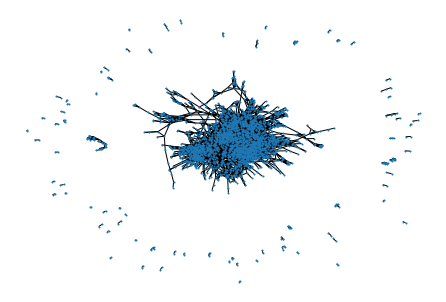

In [ ]:
X,A,gnd,cluster_= data_processing(data)
def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=1)
    plt.show()

show_graph_with_labels(A, gnd_)

In [ ]:
data = sio.loadmat('/content/cora.mat')
intra_list,acc_list,nmi_list,f1_list = AGC(data)        

power: 1  intraD:  3.5186  accuracy:  0.5458  nmi:  0.3323  f1_score:  0.5422
power: 2  intraD:  2.8025  accuracy:  0.6366  nmi:  0.4481  f1_score:  0.6349
power: 3  intraD:  2.4883  accuracy:  0.6392  nmi:  0.4758  f1_score:  0.5882
power: 4  intraD:  2.2518  accuracy:  0.6555  nmi:  0.4944  f1_score:  0.6226
power: 5  intraD:  2.0848  accuracy:  0.6673  nmi:  0.5089  f1_score:  0.636
power: 6  intraD:  1.9616  accuracy:  0.6684  nmi:  0.5147  f1_score:  0.6376
power: 7  intraD:  1.859  accuracy:  0.6765  nmi:  0.5218  f1_score:  0.6436
power: 8  intraD:  1.7704  accuracy:  0.6872  nmi:  0.5308  f1_score:  0.6557
power: 9  intraD:  1.7078  accuracy:  0.6809  nmi:  0.5262  f1_score:  0.647
power: 10  intraD:  1.6425  accuracy:  0.6883  nmi:  0.5307  f1_score:  0.6542
power: 11  intraD:  1.6749  accuracy:  0.6292  nmi:  0.512  f1_score:  0.5382
bestpower: 10
21.986461877822876


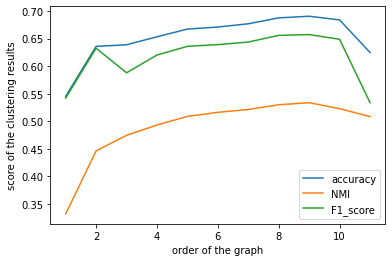

In [ ]:
k_= list(range(1, len(acc_list)+1)
plt.plot(k_,acc_list, label = "accuracy")
plt.plot(k_,nmi_list, label = "NMI")
plt.plot(k_,f1_list, label = "F1_score")
plt.legend()
plt.xlabel('order of the graph')
plt.ylabel('score of the clustering results')
plt.show()

# observations on Citeseer dataset
* ploting node and edges (from adj matrix)

* Applied AGC on citeseer dataset

* ploting metrices vs order of graph( k order graph convolution)

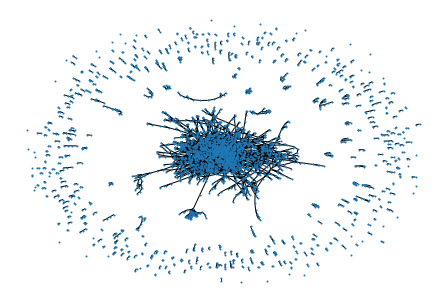

In [ ]:
data = sio.loadmat('/content/citeseer.mat')
X,A,gnd,cluster_= data_processing(data)

def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=1)
    plt.show()

show_graph_with_labels(A)

In [ ]:
data = sio.loadmat('/content/citeseer.mat')
intra_list,acc_list,nmi_list,f1_list =AGC(data)

power: 1  intraD:  5.1787  accuracy:  0.6342  nmi:  0.3707  f1_score:  0.5967
power: 2  intraD:  4.5752  accuracy:  0.6637  nmi:  0.4036  f1_score:  0.6198
power: 3  intraD:  4.282  accuracy:  0.6706  nmi:  0.4098  f1_score:  0.6266
power: 4  intraD:  4.1031  accuracy:  0.6751  nmi:  0.4159  f1_score:  0.6299
power: 5  intraD:  3.967  accuracy:  0.6742  nmi:  0.4132  f1_score:  0.6306
power: 6  intraD:  3.8697  accuracy:  0.6763  nmi:  0.4149  f1_score:  0.6321
power: 7  intraD:  3.7917  accuracy:  0.6751  nmi:  0.4128  f1_score:  0.6309
power: 8  intraD:  3.7268  accuracy:  0.6754  nmi:  0.4142  f1_score:  0.6312
power: 9  intraD:  3.6771  accuracy:  0.6808  nmi:  0.4188  f1_score:  0.6356
power: 10  intraD:  3.6321  accuracy:  0.6811  nmi:  0.4202  f1_score:  0.6357
power: 11  intraD:  3.5959  accuracy:  0.6802  nmi:  0.4188  f1_score:  0.6348
power: 12  intraD:  3.5703  accuracy:  0.6808  nmi:  0.4191  f1_score:  0.6345
power: 13  intraD:  3.5397  accuracy:  0.6805  nmi:  0.4183  f1

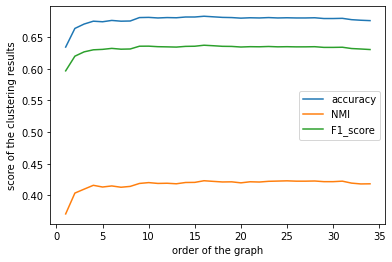

In [ ]:
k_= list(range(1, len(acc_list)+1))
plt.plot(k_,acc_list, label = "accuracy")
plt.plot(k_,nmi_list, label = "NMI")
plt.plot(k_,f1_list, label = "F1_score")
plt.legend()
plt.xlabel('order of the graph')
plt.ylabel('score of the clustering results')
plt.show()

# observations on Wiki dataset
* ploting node and edges (from adj matrix)

* Applied AGC on wiki dataset

* ploting metrices vs order of graph( k order graph convolution)

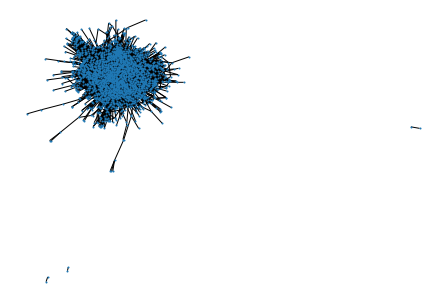

In [ ]:
data = sio.loadmat('/content/wiki.mat')
X,A,gnd,cluster_= data_processing(data)

def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=1)
    plt.show()

show_graph_with_labels(A)

In [ ]:
data = sio.loadmat('/content/wiki.mat')
intra_list,acc_list,nmi_list,f1_list = AGC(data)

power: 1  intraD:  3.4897  accuracy:  0.4328  nmi:  0.4754  f1_score:  0.3931
power: 2  intraD:  2.5032  accuracy:  0.4225  nmi:  0.4465  f1_score:  0.3498
power: 3  intraD:  2.0902  accuracy:  0.4125  nmi:  0.4344  f1_score:  0.3567
power: 4  intraD:  1.8115  accuracy:  0.4216  nmi:  0.4379  f1_score:  0.3578
power: 5  intraD:  1.4956  accuracy:  0.3913  nmi:  0.4169  f1_score:  0.3369
power: 6  intraD:  1.3701  accuracy:  0.4678  nmi:  0.4385  f1_score:  0.3851
power: 7  intraD:  1.4103  accuracy:  0.4503  nmi:  0.4316  f1_score:  0.3875
bestpower: 6
27.865774154663086


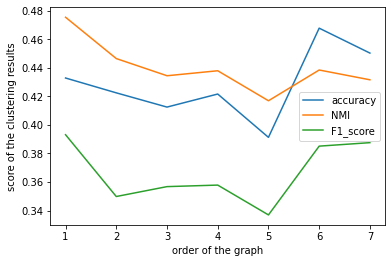

In [ ]:
k_= list(range(1, len(acc_list)+1))
plt.plot(k_,acc_list, label = "accuracy")
plt.plot(k_,nmi_list, label = "NMI")
plt.plot(k_,f1_list, label = "F1_score")
plt.legend()
plt.xlabel('order of the graph')
plt.ylabel('score of the clustering results')
plt.show()

# observations on Pubmed dataset
* ploting node and edges (from adj matrix)

* Applied AGC on Pubmed dataset

* ploting metrices vs order of graph( k order graph convolution)

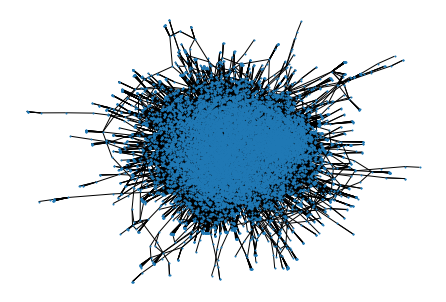

In [ ]:
data = sio.loadmat('/content/pubmed.mat')
X,A,gnd,cluster_= data_processing(data)

def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=1)
    plt.show()

show_graph_with_labels(A)

In [ ]:
data = sio.loadmat('/content/pubmed.mat')
intra_list,acc_list,nmi_list,f1_list =AGC(data)

power: 1  intraD:  0.174  accuracy:  0.6076  nmi:  0.3401  f1_score:  0.5947
power: 2  intraD:  0.1132  accuracy:  0.6125  nmi:  0.3414  f1_score:  0.6
power: 3  intraD:  0.0821  accuracy:  0.6129  nmi:  0.3338  f1_score:  0.5995
power: 4  intraD:  0.0645  accuracy:  0.6151  nmi:  0.3271  f1_score:  0.6017
power: 5  intraD:  0.0533  accuracy:  0.6178  nmi:  0.3217  f1_score:  0.6048
power: 6  intraD:  0.0458  accuracy:  0.6205  nmi:  0.3146  f1_score:  0.6083
power: 7  intraD:  0.0404  accuracy:  0.6219  nmi:  0.3057  f1_score:  0.6102
power: 8  intraD:  0.0364  accuracy:  0.625  nmi:  0.3017  f1_score:  0.6137
power: 9  intraD:  0.0332  accuracy:  0.6274  nmi:  0.2993  f1_score:  0.6166
power: 10  intraD:  0.0307  accuracy:  0.6319  nmi:  0.3003  f1_score:  0.6215
power: 11  intraD:  0.0286  accuracy:  0.6349  nmi:  0.2999  f1_score:  0.6248
power: 12  intraD:  0.0267  accuracy:  0.6389  nmi:  0.3007  f1_score:  0.6294
power: 13  intraD:  0.0251  accuracy:  0.6419  nmi:  0.3006  f1_sc

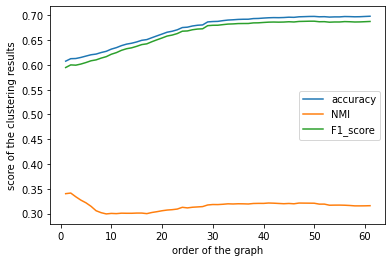

In [ ]:
k_= list(range(1, len(acc_list)+1))
plt.plot(k_,acc_list, label = "accuracy")
plt.plot(k_,nmi_list, label = "NMI")
plt.plot(k_,f1_list, label = "F1_score")
plt.legend()
plt.xlabel('order of the graph')
plt.ylabel('score of the clustering results')
plt.show()

# final result of the model

In [8]:
import pandas as pd

cars = {'Accuracy': [68.83,68.05,46.78,69.82],
        'Nmi': [53.07,42.29,43.85,31.58],
        'F1_score': [65.42,63.48,38.51,68.77],
        'Order': [10,15,6,61],
        }


df = pd.DataFrame(cars, columns = ['Accuracy','Nmi','F1_score','Order'], index=['Cora','Citeseer','Wiki','Pubmed'])

df

,Accuracy,Nmi,F1_score,Order
Cora,68.83,53.07,65.42,10
Citeseer,68.05,42.29,63.48,15
Wiki,46.78,43.85,38.51,6
Pubmed,69.82,31.58,68.77,61
